In [94]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
# import sys
# !{sys.executable} -m pip install kmodes
from kmodes.kmodes import KModes



In [95]:
conn = psycopg2.connect(database = "dsa3101", 
                        user = "postgres", 
                        host= 'localhost',
                        password = "t0220514e",
                        port = 5433)

## Part 1: Analyze historical sales

In [96]:
# get daily_sales table

cur = conn.cursor()
cur.execute('SELECT * FROM daily_sales;')
rows = cur.fetchall()
column_names = [desc[0] for desc in cur.description]
daily_sales = pd.DataFrame(rows, columns=column_names)
daily_sales

,transaction_id,date,product_id,quantity
0,1601,2018-03-21,B014I8SX4Y,1
1,2872,2022-11-27,B014I8SSD0,1
2,4832,2018-04-12,B06XR9PR5X,1
3,5496,2020-12-24,B015OW3M1W,1
4,7115,2019-08-24,B006LW0WDQ,1
...,...,...,...,...
882,1847559,2022-01-09,B003L62T7W,1
883,1849170,2021-02-02,B014I8SSD0,1
884,1849692,2022-03-17,B015OW3M1W,1
885,1850677,2018-10-11,B01J8S6X2I,1


In [97]:
# get products table

cur.execute('SELECT * FROM products;')
rows = cur.fetchall()
column_names = [desc[0] for desc in cur.description]
products = pd.DataFrame(rows, columns=column_names)
products

,product_id,product_name,about_product,category,actual_price,discounted_price,discount_percentage
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,High Compatibility : Compatible With iPhone 12...,Computers&Accessories|Accessories&Peripherals|...,13.19,4.79,0.64
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,"Compatible with all Type C enabled devices, be...",Computers&Accessories|Accessories&Peripherals|...,4.19,2.39,0.43
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,【 Fast Charger& Data Sync】-With built-in safet...,Computers&Accessories|Accessories&Peripherals|...,22.79,2.39,0.90
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,The boAt Deuce USB 300 2 in 1 cable is compati...,Computers&Accessories|Accessories&Peripherals|...,8.39,3.95,0.53
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,[CHARGE & SYNC FUNCTION]- This cable comes wit...,Computers&Accessories|Accessories&Peripherals|...,4.79,1.85,0.61
...,...,...,...,...,...,...,...
1346,B00TI8E7BI,Philips HD9306/06 1.5-Litre Electric Kettle (M...,"Food grade stainless steel, Frequency: 50 Hz. ...",Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,32.34,32.34,0.00
1347,B07J9KXQCC,"Libra Room Heater for Home, Room Heaters Home ...","Libra room heater for home has cool, warm or h...","Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",27.59,11.39,0.59
1348,B0B3JSWG81,NGI Store 2 Pieces Pet Hair Removers for Your ...,"Versatile, Protects Your Clothes: MoveCatcher ...","Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle...",11.99,2.39,0.80
1349,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,11.03,4.55,0.59


In [98]:
# get user_behaviour table

cur.execute('SELECT * FROM user_behaviour;')
rows = cur.fetchall()
column_names = [desc[0] for desc in cur.description]
user_behaviour = pd.DataFrame(rows, columns=column_names)
user_behaviour

,user_id,timestamp,purchase_Frequency,purchase_Categories,personalized_Recommendation_Success,browsing_Frequency,product_Search_Method,search_Result_Exploration,customer_Reviews_Importance,add_to_Cart_Browsing,...,saveforlater_Frequency,review_Left,review_Reliability,review_Helpfulness,recommendation_Helpfulness,personalized_Recommendation_Frequency,rating_Accuracy,shopping_Satisfaction,service_Appreciation,improvement_Areas
0,1,2023-06-04 13:28:19,Few times a month,Beauty and Personal Care,Yes,Few times a week,Keyword,Multiple pages,1,Yes,...,Sometimes,Yes,Occasionally,Yes,Yes,2,1,1,Competitive prices,Reducing packaging waste
1,2,2023-06-04 14:30:44,Once a month,Clothing and Fashion,Yes,Few times a month,Keyword,Multiple pages,1,Yes,...,Rarely,No,Heavily,Yes,Sometimes,2,3,2,Wide product selection,Reducing packaging waste
2,3,2023-06-04 17:04:56,Few times a month,Groceries and Gourmet Food;Clothing and Fashion,No,Few times a month,Keyword,Multiple pages,2,Yes,...,Rarely,No,Occasionally,No,No,4,3,3,Competitive prices,Product quality and accuracy
3,4,2023-06-04 17:13:00,Once a month,Beauty and Personal Care;Clothing and Fashion;...,Sometimes,Few times a month,Keyword,First page,5,Maybe,...,Sometimes,Yes,Heavily,Yes,Sometimes,3,3,4,Competitive prices,Product quality and accuracy
4,5,2023-06-04 17:28:06,Less than once a month,Beauty and Personal Care;Clothing and Fashion,Yes,Few times a month,Filter,Multiple pages,1,Yes,...,Rarely,No,Heavily,Yes,Yes,4,2,2,Competitive prices,Product quality and accuracy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,598,2023-06-12 16:02:02,Once a week,Beauty and Personal Care,Sometimes,Few times a week,categories,Multiple pages,4,Maybe,...,Sometimes,Yes,Moderately,Sometimes,Sometimes,3,3,4,Competitive prices,Customer service responsiveness
598,599,2023-06-12 16:02:53,Once a week,Clothing and Fashion,Sometimes,Few times a week,Filter,Multiple pages,3,Maybe,...,Sometimes,Yes,Heavily,Sometimes,Sometimes,3,3,3,Product recommendations,Reducing packaging waste
599,600,2023-06-12 16:03:59,Once a month,Beauty and Personal Care,Sometimes,Few times a week,categories,Multiple pages,3,Maybe,...,Sometimes,Yes,Occasionally,Sometimes,Sometimes,3,2,3,Wide product selection,Product quality and accuracy
600,601,2023-06-12 21:57:20,Few times a month,Beauty and Personal Care;Clothing and Fashion;...,Yes,Few times a month,Keyword,Multiple pages,1,Yes,...,Sometimes,No,Heavily,Yes,Yes,2,2,2,Wide product selection,Product quality and accuracy


In [99]:
# get users table

cur.execute('SELECT * FROM users;')
rows = cur.fetchall()
column_names = [desc[0] for desc in cur.description]
users = pd.DataFrame(rows, columns=column_names)
users

,user_id,age,gender
0,1,23,Female
1,2,23,Female
2,3,24,Prefer not to say
3,4,24,Female
4,5,22,Female
...,...,...,...
597,598,23,Female
598,599,23,Female
599,600,23,Female
600,601,23,Female


## **EDA**

In [100]:
user_behaviour.info()
user_behaviour_categoricals = user_behaviour.select_dtypes(include=['object'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   user_id                                602 non-null    int64         
 1   timestamp                              602 non-null    datetime64[ns]
 2   purchase_Frequency                     602 non-null    object        
 3   purchase_Categories                    602 non-null    object        
 4   personalized_Recommendation_Success    602 non-null    object        
 5   browsing_Frequency                     602 non-null    object        
 6   product_Search_Method                  600 non-null    object        
 7   search_Result_Exploration              602 non-null    object        
 8   customer_Reviews_Importance            602 non-null    object        
 9   add_to_Cart_Browsing                   602 non-null    object    

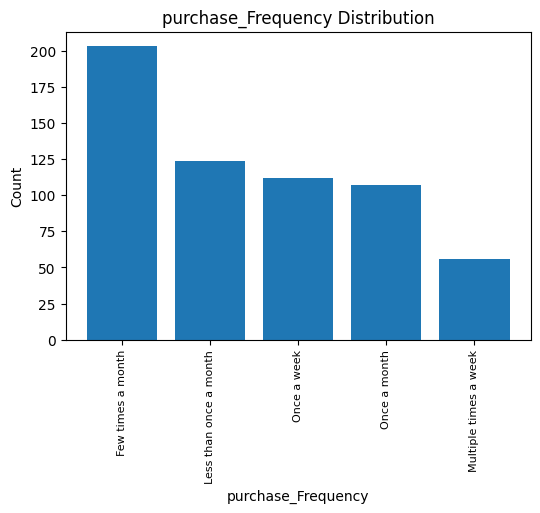

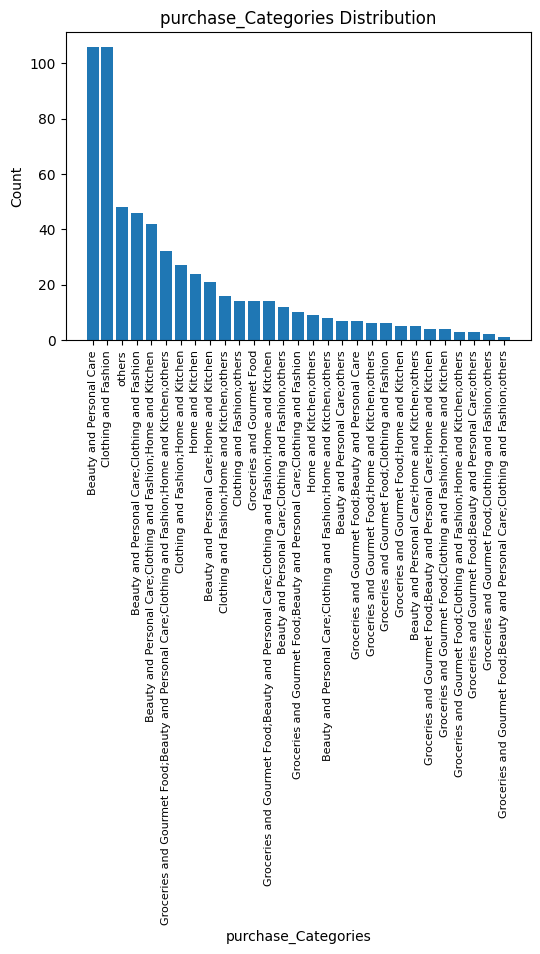

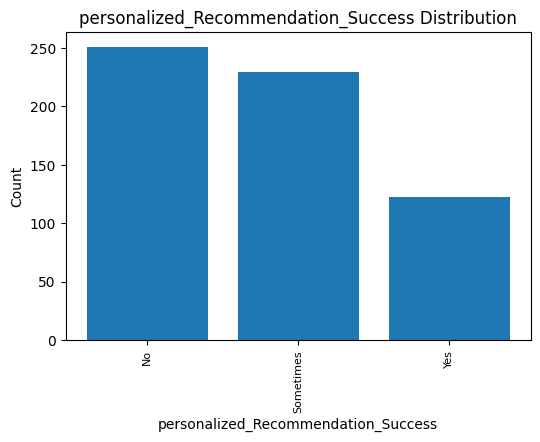

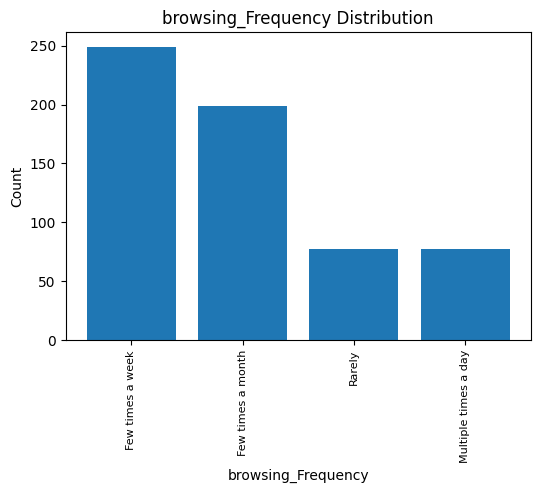

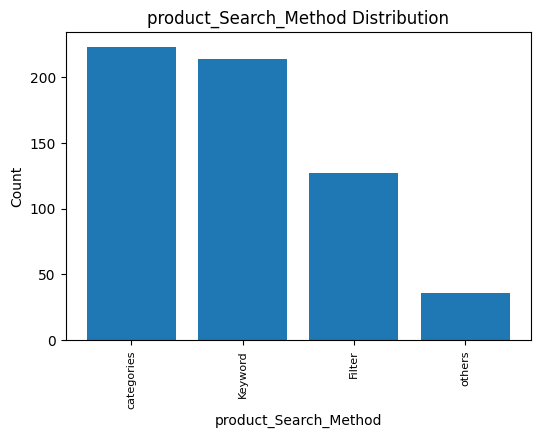

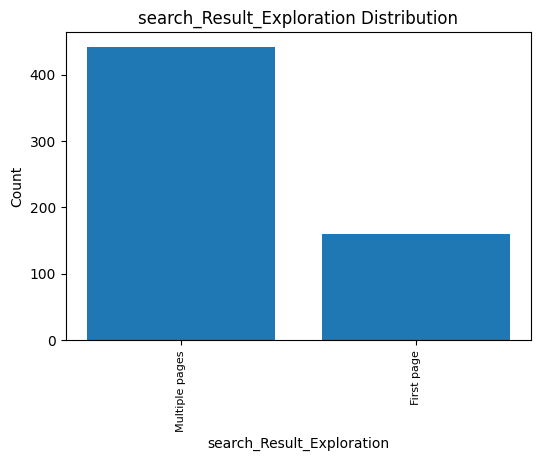

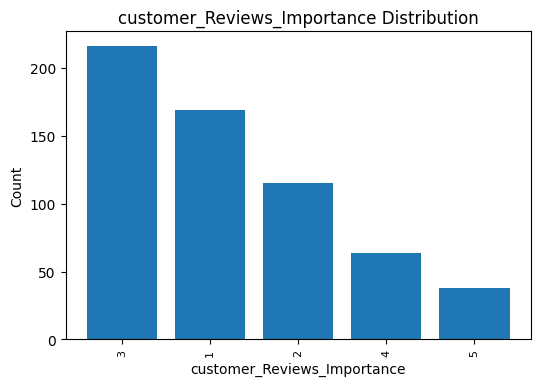

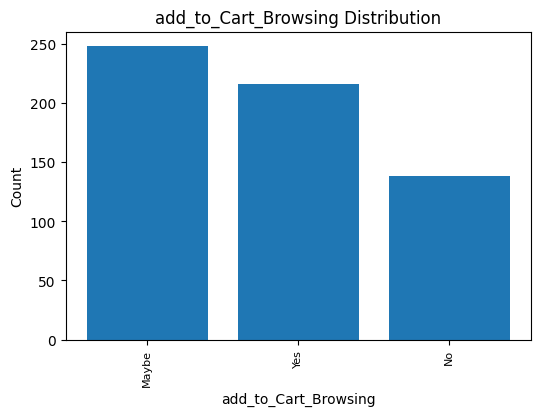

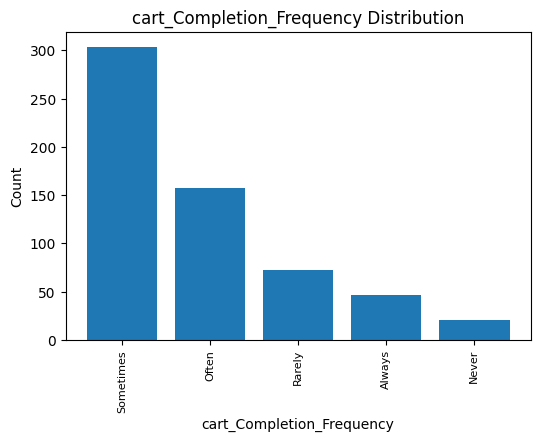

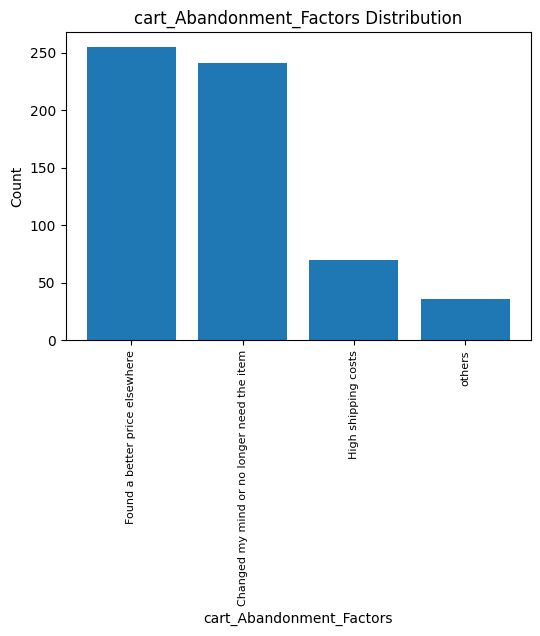

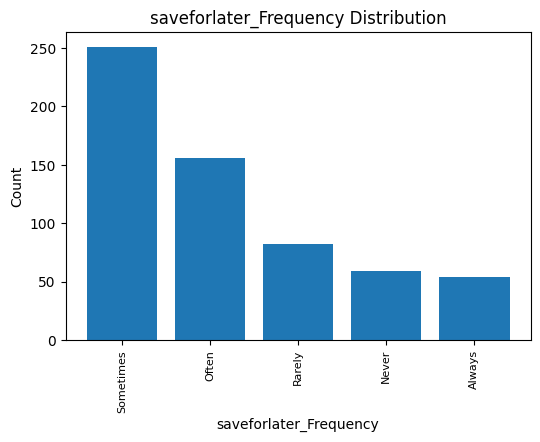

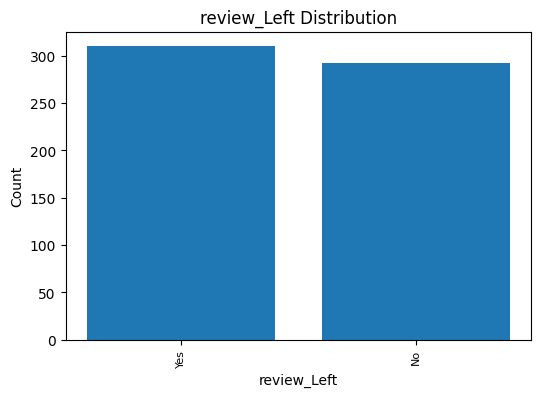

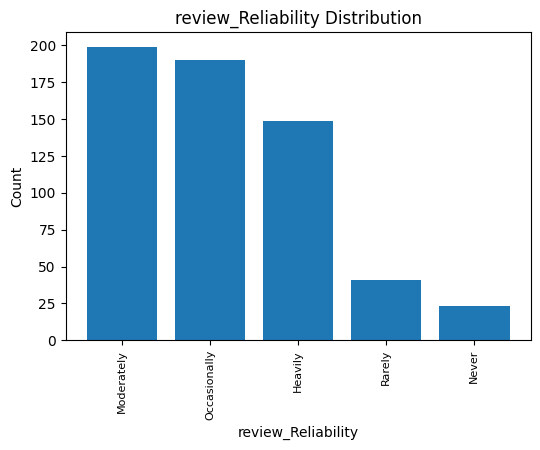

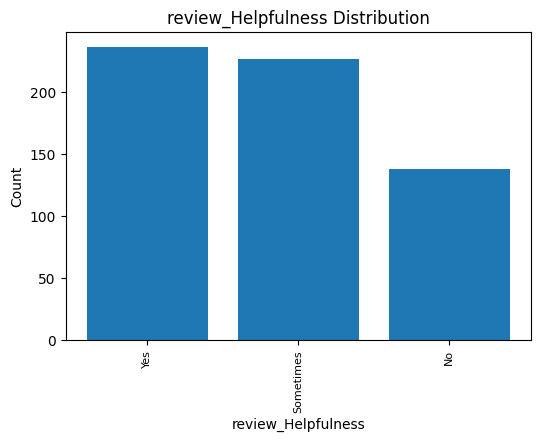

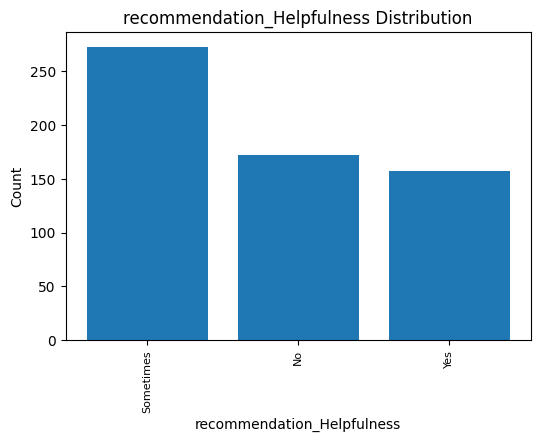

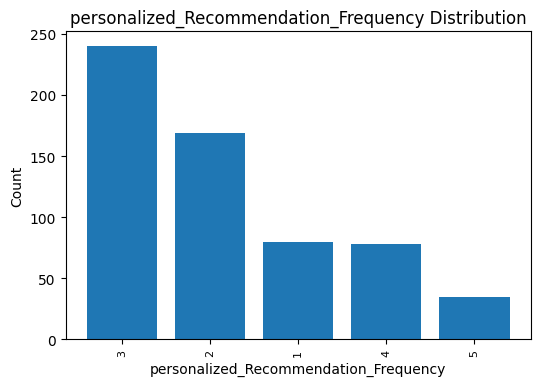

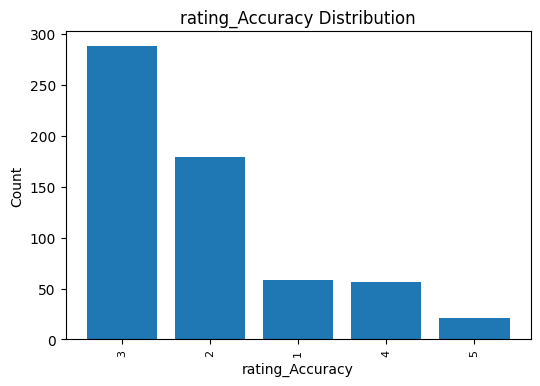

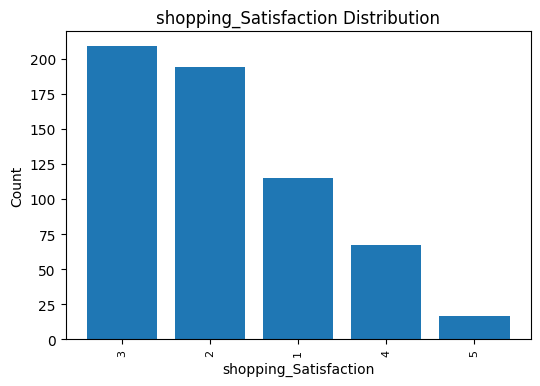

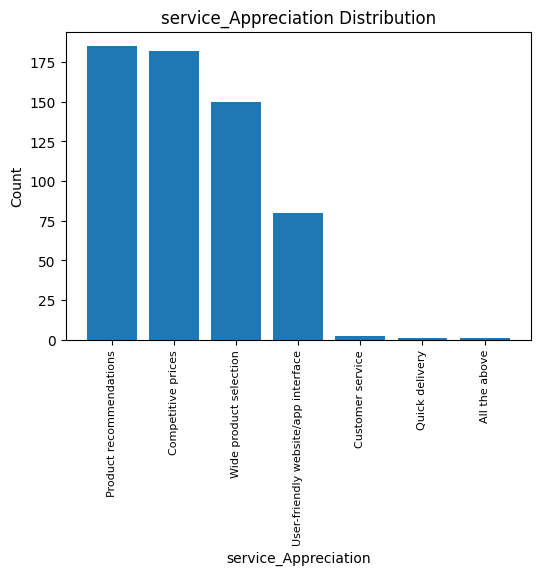

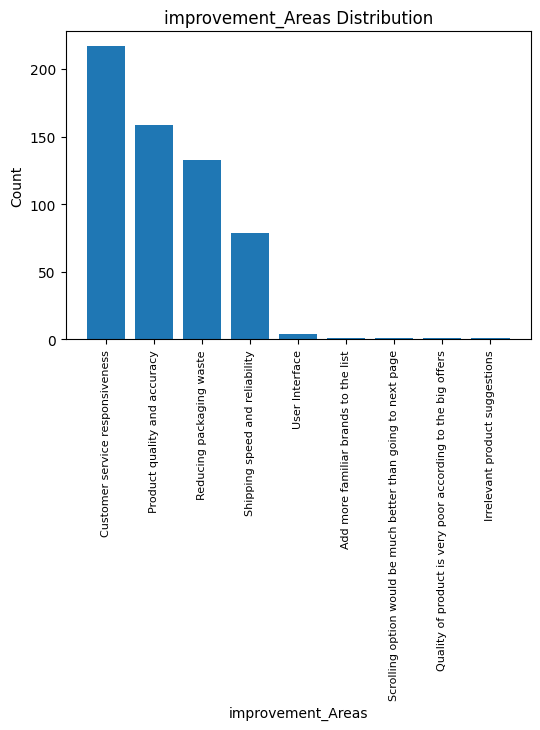

In [101]:
# visualise categorical variables in user_behaviour

def plot_one_by_one(df, categories):
    for category in categories:
        cat_count = df[category].value_counts()
        plt.figure(figsize=(6, 4))
        plt.bar(cat_count.index, cat_count.values)
        plt.title(f'{category} Distribution')
        plt.xlabel(category)
        plt.ylabel('Count')
        plt.xticks(rotation=90, fontsize=8)  # Rotate for readability
        
        # Show the plot for each category, then wait for user input before moving to the next one
        plt.show()
        input(f"Press Enter to view the next plot for '{category}'...")

plot_one_by_one(user_behaviour, user_behaviour_categoricals)


In [102]:
new_users = users.copy()

# Regroup users based on age range which are more relevant to the business context
bins = [0, 19, 24, 55, 100]
labels = ['Teenager', 'Young Adult', 'Adult', 'Senior']
new_users['age_group'] = pd.cut(new_users['age'], bins=bins, labels=labels)

new_users['age_group'].value_counts()
new_users

,user_id,age,gender,age_group
0,1,23,Female,Young Adult
1,2,23,Female,Young Adult
2,3,24,Prefer not to say,Young Adult
3,4,24,Female,Young Adult
4,5,22,Female,Young Adult
...,...,...,...,...
597,598,23,Female,Young Adult
598,599,23,Female,Young Adult
599,600,23,Female,Young Adult
600,601,23,Female,Young Adult


In [103]:
# Join user_behaviour and users dataframe on user_id
new_user_behaviour = user_behaviour.copy()
new_user_behaviour = new_user_behaviour.merge(new_users[['user_id', 'age', 'gender', 'age_group']], on='user_id', how='left')
new_user_behaviour

,user_id,timestamp,purchase_Frequency,purchase_Categories,personalized_Recommendation_Success,browsing_Frequency,product_Search_Method,search_Result_Exploration,customer_Reviews_Importance,add_to_Cart_Browsing,...,review_Helpfulness,recommendation_Helpfulness,personalized_Recommendation_Frequency,rating_Accuracy,shopping_Satisfaction,service_Appreciation,improvement_Areas,age,gender,age_group
0,1,2023-06-04 13:28:19,Few times a month,Beauty and Personal Care,Yes,Few times a week,Keyword,Multiple pages,1,Yes,...,Yes,Yes,2,1,1,Competitive prices,Reducing packaging waste,23,Female,Young Adult
1,2,2023-06-04 14:30:44,Once a month,Clothing and Fashion,Yes,Few times a month,Keyword,Multiple pages,1,Yes,...,Yes,Sometimes,2,3,2,Wide product selection,Reducing packaging waste,23,Female,Young Adult
2,3,2023-06-04 17:04:56,Few times a month,Groceries and Gourmet Food;Clothing and Fashion,No,Few times a month,Keyword,Multiple pages,2,Yes,...,No,No,4,3,3,Competitive prices,Product quality and accuracy,24,Prefer not to say,Young Adult
3,4,2023-06-04 17:13:00,Once a month,Beauty and Personal Care;Clothing and Fashion;...,Sometimes,Few times a month,Keyword,First page,5,Maybe,...,Yes,Sometimes,3,3,4,Competitive prices,Product quality and accuracy,24,Female,Young Adult
4,5,2023-06-04 17:28:06,Less than once a month,Beauty and Personal Care;Clothing and Fashion,Yes,Few times a month,Filter,Multiple pages,1,Yes,...,Yes,Yes,4,2,2,Competitive prices,Product quality and accuracy,22,Female,Young Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,598,2023-06-12 16:02:02,Once a week,Beauty and Personal Care,Sometimes,Few times a week,categories,Multiple pages,4,Maybe,...,Sometimes,Sometimes,3,3,4,Competitive prices,Customer service responsiveness,23,Female,Young Adult
598,599,2023-06-12 16:02:53,Once a week,Clothing and Fashion,Sometimes,Few times a week,Filter,Multiple pages,3,Maybe,...,Sometimes,Sometimes,3,3,3,Product recommendations,Reducing packaging waste,23,Female,Young Adult
599,600,2023-06-12 16:03:59,Once a month,Beauty and Personal Care,Sometimes,Few times a week,categories,Multiple pages,3,Maybe,...,Sometimes,Sometimes,3,2,3,Wide product selection,Product quality and accuracy,23,Female,Young Adult
600,601,2023-06-12 21:57:20,Few times a month,Beauty and Personal Care;Clothing and Fashion;...,Yes,Few times a month,Keyword,Multiple pages,1,Yes,...,Yes,Yes,2,2,2,Wide product selection,Product quality and accuracy,23,Female,Young Adult


In [104]:
# drop user with age 3
new_user_behaviour['age'] = new_user_behaviour['age'].astype(int)
new_user_behaviour = new_user_behaviour[users['age'] != 3.0]
new_user_behaviour['age'].value_counts()

age
23    123
34     48
24     40
25     36
45     34
21     30
26     27
32     19
27     17
22     17
36     16
35     15
37     14
40     12
46     12
29      9
31      9
28      9
30      8
56      8
33      7
18      7
47      6
54      6
43      6
50      5
44      5
20      5
16      5
38      4
41      4
42      4
19      4
17      4
39      4
60      3
48      3
67      2
15      2
57      2
53      2
62      1
64      1
49      1
63      1
58      1
52      1
55      1
12      1
Name: count, dtype: int64

In [105]:
# Reduce number of categories in purchase_Categories

new_user_behaviour['purchase_Categories'] = new_user_behaviour['purchase_Categories'].apply(lambda x: x.split(";")[0] if ";" in x else x)
new_user_behaviour['purchase_Categories'].value_counts()

/var/folders/gd/v8v96pt94wl6b52w5qldf23m0000gn/T/ipykernel_17859/430396605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_user_behaviour['purchase_Categories'] = new_user_behaviour['purchase_Categories'].apply(lambda x: x.split(";")[0] if ";" in x else x)


purchase_Categories
Beauty and Personal Care      247
Clothing and Fashion          163
Groceries and Gourmet Food    111
others                         48
Home and Kitchen               32
Name: count, dtype: int64

In [106]:
# Reduce number of categories in improvement_Areas
new_user_behaviour['improvement_Areas'] = new_user_behaviour['improvement_Areas'].replace({
    "Add more familiar brands to the list": "Others",
    "Scrolling option would be much better than going to next page" : "User Interface",
    "Quality of product is very poor according to the big offers" : "Product quality and accuracy",
    "Irrelevant product suggestions" : "Others"
})
new_user_behaviour['improvement_Areas'].value_counts()

/var/folders/gd/v8v96pt94wl6b52w5qldf23m0000gn/T/ipykernel_17859/2807220974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_user_behaviour['improvement_Areas'] = new_user_behaviour['improvement_Areas'].replace({


improvement_Areas
Customer service responsiveness    216
Product quality and accuracy       160
Reducing packaging waste           133
Shipping speed and reliability      79
User Interface                       5
Others                               2
Name: count, dtype: int64

In [107]:
# Implement label encoding for categorical variables in user_behaviour
le=LabelEncoder()

encoded_user_behaviour = new_user_behaviour.copy()
for i in encoded_user_behaviour.columns:
  encoded_user_behaviour[i]=le.fit_transform(encoded_user_behaviour[i])

user_behaviour_corr = encoded_user_behaviour.drop(['user_id', 'timestamp', "age"], axis= 1)

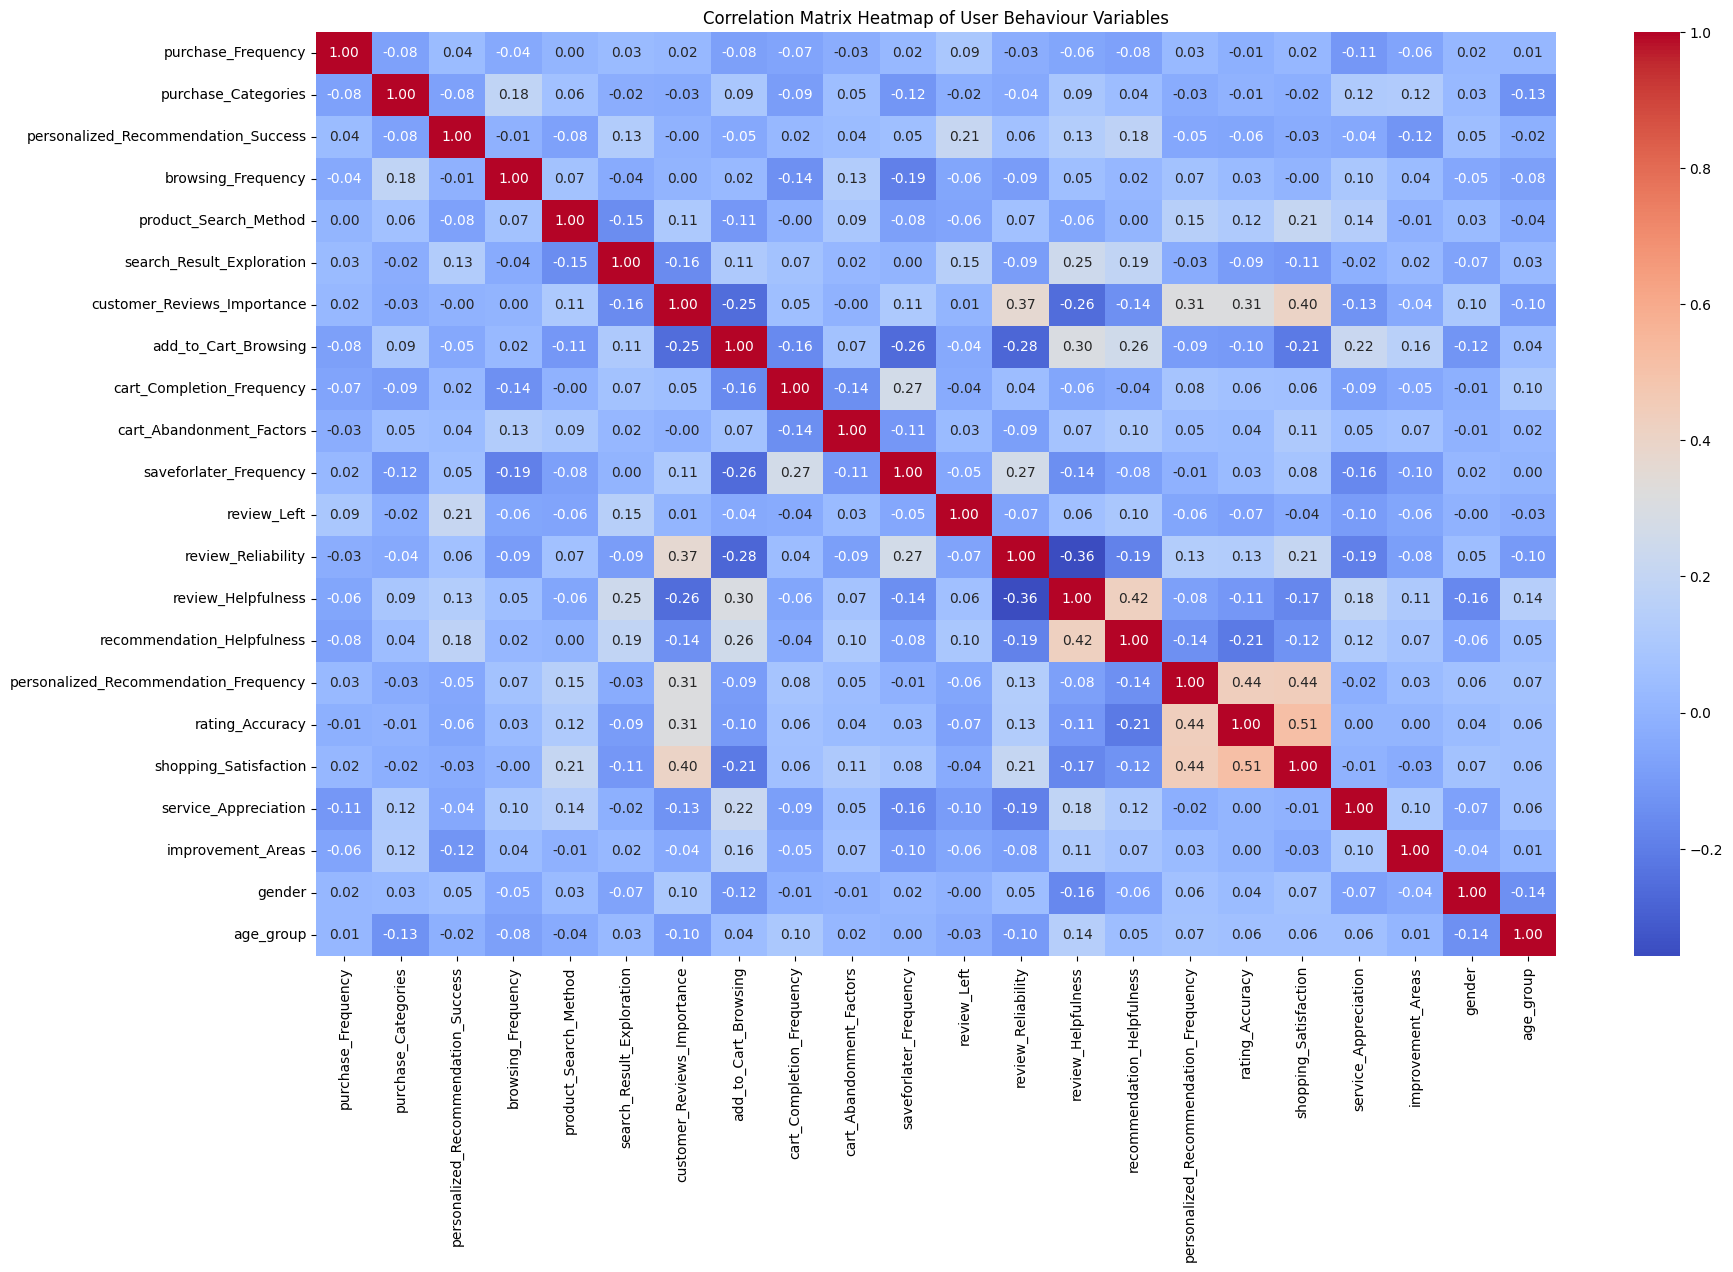

In [108]:
correlation_matrix = user_behaviour_corr.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix Heatmap of User Behaviour Variables")
plt.show()

None of the features are strongly correlated to each other.

In [109]:
new_user_behaviour

,user_id,timestamp,purchase_Frequency,purchase_Categories,personalized_Recommendation_Success,browsing_Frequency,product_Search_Method,search_Result_Exploration,customer_Reviews_Importance,add_to_Cart_Browsing,...,review_Helpfulness,recommendation_Helpfulness,personalized_Recommendation_Frequency,rating_Accuracy,shopping_Satisfaction,service_Appreciation,improvement_Areas,age,gender,age_group
0,1,2023-06-04 13:28:19,Few times a month,Beauty and Personal Care,Yes,Few times a week,Keyword,Multiple pages,1,Yes,...,Yes,Yes,2,1,1,Competitive prices,Reducing packaging waste,23,Female,Young Adult
1,2,2023-06-04 14:30:44,Once a month,Clothing and Fashion,Yes,Few times a month,Keyword,Multiple pages,1,Yes,...,Yes,Sometimes,2,3,2,Wide product selection,Reducing packaging waste,23,Female,Young Adult
2,3,2023-06-04 17:04:56,Few times a month,Groceries and Gourmet Food,No,Few times a month,Keyword,Multiple pages,2,Yes,...,No,No,4,3,3,Competitive prices,Product quality and accuracy,24,Prefer not to say,Young Adult
3,4,2023-06-04 17:13:00,Once a month,Beauty and Personal Care,Sometimes,Few times a month,Keyword,First page,5,Maybe,...,Yes,Sometimes,3,3,4,Competitive prices,Product quality and accuracy,24,Female,Young Adult
4,5,2023-06-04 17:28:06,Less than once a month,Beauty and Personal Care,Yes,Few times a month,Filter,Multiple pages,1,Yes,...,Yes,Yes,4,2,2,Competitive prices,Product quality and accuracy,22,Female,Young Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,598,2023-06-12 16:02:02,Once a week,Beauty and Personal Care,Sometimes,Few times a week,categories,Multiple pages,4,Maybe,...,Sometimes,Sometimes,3,3,4,Competitive prices,Customer service responsiveness,23,Female,Young Adult
598,599,2023-06-12 16:02:53,Once a week,Clothing and Fashion,Sometimes,Few times a week,Filter,Multiple pages,3,Maybe,...,Sometimes,Sometimes,3,3,3,Product recommendations,Reducing packaging waste,23,Female,Young Adult
599,600,2023-06-12 16:03:59,Once a month,Beauty and Personal Care,Sometimes,Few times a week,categories,Multiple pages,3,Maybe,...,Sometimes,Sometimes,3,2,3,Wide product selection,Product quality and accuracy,23,Female,Young Adult
600,601,2023-06-12 21:57:20,Few times a month,Beauty and Personal Care,Yes,Few times a month,Keyword,Multiple pages,1,Yes,...,Yes,Yes,2,2,2,Wide product selection,Product quality and accuracy,23,Female,Young Adult


In [110]:
data = new_user_behaviour[['age_group', 'gender', 'purchase_Frequency']]

km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(data)

# Add the cluster column to the DataFrame
data['Cluster'] = clusters
data.groupby('Cluster').size()
# Show results
print(km.cluster_centroids_)
print(km.cost_)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 670.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 15, cost: 634.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 220, cost: 647.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 43, cost: 663.0
Best run was number 2
[['Young Adult' 'Female' 'Few times a month']
 ['Adult' 'Female' 'Less than once a month']
 ['Adult' 'Prefer not to say' 'Few times a month']]
634.0


/var/folders/gd/v8v96pt94wl6b52w5qldf23m0000gn/T/ipykernel_17859/644026102.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = clusters


<Axes: xlabel='age_group', ylabel='purchase_Frequency'>

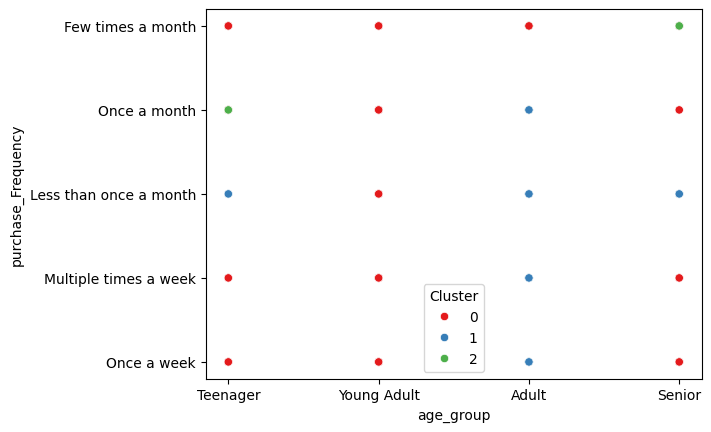

In [111]:
sns.scatterplot(data=data, x='age_group', y='purchase_Frequency', hue='Cluster', palette='Set1')